In [2]:
RANDOM_SEED = 42
TRAIN_METADATA = './data/train_ship_segmentations_v2.csv'
TRAIN_PATH = './data/train_v2/'
IMAGE_SIZE = 768
TARGET_SIZE = 256
BATCH_SIZE = 16
OUTPUT = './model/'
MODEL_PATH = OUTPUT + 'trained_model.h5'
TRAIN_SIZE = 30000
USE_EXISTING = True

In [3]:
import tensorflow as tf
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.__version__)
if tf.test.gpu_device_name():
	print('GPU found')
else:
	print("No GPU found")


C:\Users\Sauron\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


2.10.0
GPU found


In [4]:
import numpy as np
import pandas as pd
import re
from PIL import Image
import matplotlib.pyplot as plt
import h5py


In [5]:

# Load the CSV file into a DataFrame
all_metadata_pd = pd.read_csv(TRAIN_METADATA).dropna(subset=['EncodedPixels']).sample(TRAIN_SIZE).reset_index(drop=True)
all_metadata = np.array(all_metadata_pd)
# Print the DataFrame
print(all_metadata_pd.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        30000 non-null  object
 1   EncodedPixels  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB
None


In [6]:
def get_image_path(image_id):
	return TRAIN_PATH + image_id

In [7]:
def decode_pixels(rle_encoding, shape):
	mask = np.zeros(shape, dtype=int)
	for start, length in rle_encoding:
		end = start + length
		mask.flat[start:end] = 1
	
	return np.rot90(np.fliplr(mask))

In [8]:

def str2rle(rle_string: str):
	if isinstance(rle_string, str) and len(rle_string.strip()) > 0:
		str_pairs = re.findall(r"\d+ \d+", rle_string)
		return list(map(lambda str_pair: list(map(lambda str_num: int(str_num), str_pair.split(' '))), str_pairs))
	else: 
		return []

In [9]:
def get_mask(rle_string, shape):
	return decode_pixels(str2rle(rle_string), shape)

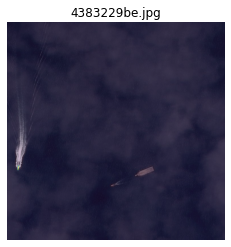

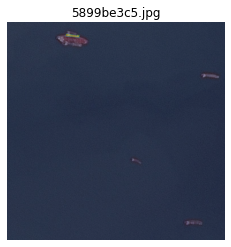

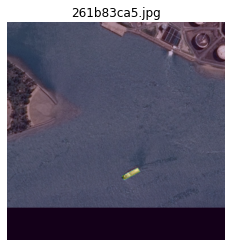

In [10]:
def render_pair(title, image, mask):
	plt.imshow(image)
	plt.imshow(mask, alpha=0.3)
	plt.axis('off')
	plt.title(title)
	plt.show()
	
def render_image(row):
	path = get_image_path(row[0])

	image = Image.open(path)
	mask = get_mask(row[1], (IMAGE_SIZE, IMAGE_SIZE))
	# Display the image
	render_pair(row[0], image, mask)
	
render_image(all_metadata[len(all_metadata) // 7])
render_image(all_metadata[len(all_metadata) // 3])
render_image(all_metadata[len(all_metadata) // 2])

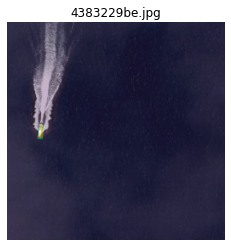

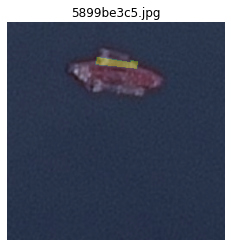

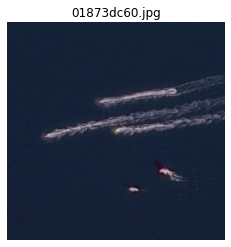

In [11]:
def get_image(img_name):
	image_path = get_image_path(img_name)
	image = Image.open(image_path)
	return np.array(image)

def get_image_mask(rle):
	return get_mask(rle, (IMAGE_SIZE, IMAGE_SIZE))

def get_bbox(mask):
	# Find the non-zero indices
	nonzero_indices = np.nonzero(mask)

	# Calculate the bounding box coordinates
	min_row = np.min(nonzero_indices[0])
	max_row = np.max(nonzero_indices[0])
	min_col = np.min(nonzero_indices[1])
	max_col = np.max(nonzero_indices[1])
	return (min_row, min_col), (max_row, max_col)

def get_image_region(image, center_x, center_y, size):
	top_left_x = max(center_x - size // 2, 0)
	top_left_y = max(center_y - size // 2, 0)

	if top_left_x + size > image.shape[1]:
		top_left_x = image.shape[1] - size
	if top_left_y + size > image.shape[0]:
		top_left_y = image.shape[0] - size

	# Define slice for rows and columns
	rows_slice = slice(top_left_y, top_left_y + size)
	cols_slice = slice(top_left_x, top_left_x + size)

	# Extract the square region from the image
	return image[rows_slice, cols_slice]

def get_resized_image(row):
	image = get_image(row[0])
	mask = get_image_mask(row[1])
	top_left, bottom_right = get_bbox(mask)
	center_x = (top_left[1] + bottom_right[1]) // 2
	center_y = (top_left[0] + bottom_right[0]) // 2
	resized_image = get_image_region(image, center_x, center_y, TARGET_SIZE)
	resized_mask = get_image_region(mask, center_x, center_y, TARGET_SIZE)
	return resized_image, resized_mask

def render_resized_image(row):
	image, mask = get_resized_image(row)

	# Display the image
	plt.imshow(image)
	plt.imshow(mask, alpha=0.3)
	plt.axis('off')
	plt.title(row[0])
	plt.show()
	
render_resized_image(all_metadata[len(all_metadata) // 7])
render_resized_image(all_metadata[len(all_metadata) // 3])
render_resized_image(all_metadata[len(all_metadata) * 2 // 3])


In [12]:

def data_generator(metadata, batch_size):
	num_samples = len(metadata)
	rand = np.random.RandomState(seed=RANDOM_SEED)
	while True:
		indices = rand.randint(0, num_samples, batch_size)
		batch_images = []
		batch_labels = []
		for idx in indices:
			image, mask = get_resized_image(metadata[idx])
			batch_images.append(image * 1.0 / 255)
			batch_labels.append(mask)
		yield np.array(batch_images), np.array(batch_labels)

In [13]:
def percentage_of_ships(data, size): 
	percentages = list(map(lambda row: 1.0 * np.sum(row[1]) / (size * size), data))
	return np.sum(percentages) / len(percentages)

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(
	all_metadata, test_size=0.2, random_state=RANDOM_SEED
)
train_generator = data_generator(train_data, batch_size=BATCH_SIZE)
val_generator = data_generator(val_data, batch_size=BATCH_SIZE)

batch_data = next(data_generator(train_data, batch_size=BATCH_SIZE))
print(percentage_of_ships(batch_data, TARGET_SIZE))


0.3685067868700215


In [15]:
from tensorflow import keras
from tensorflow.keras.layers import (
	Conv2D,
	Conv2DTranspose,
	MaxPooling2D,
	Dropout,
	concatenate,
	Input,
)


def conv_block(inputs, filters, kernel_size=3, activation="relu", padding="same", dropout_rate=0.0):
	conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
	conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
	if dropout_rate > 0.0:
		conv = Dropout(dropout_rate)(conv)
	return conv


def unet(input_shape, target_shape, num_classes, filters=[64, 128, 256, 512, 1024], dropout_rate=0.0):
	inputs = Input(input_shape)
	inputs = Input(input_shape)

	resized_inputs = tf.image.resize(inputs, target_shape)

	# Contracting Path (Encoder)
	convs = []
	pool = resized_inputs
	for filter_size in filters[:-1]:
		conv = conv_block(pool, filter_size, dropout_rate=dropout_rate)
		convs.append(conv)
		pool = MaxPooling2D(pool_size=(2, 2))(conv)

	# Bottleneck
	bottleneck = conv_block(pool, filters[-1], dropout_rate=dropout_rate)

	# Expanding Path (Decoder)
	up = bottleneck
	for i in range(len(filters) - 2, -1, -1):
		up = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding="same")(up)
		concat = concatenate([up, convs[i]], axis=3)
		up = conv_block(concat, filters[i], dropout_rate=dropout_rate)

	# Output
	outputs = Conv2D(1, 1, activation="sigmoid", padding="same")(up)
	resized_output = tf.image.resize(outputs, input_shape[:2])	
	model = keras.models.Model(inputs=inputs, outputs=resized_output)

	return model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Define the Dice coefficient metric function
def dice_coefficient2(y_true, y_pred, smooth=1e-7):
	y_true_flat = K.flatten(y_true)
	y_pred_flat_float = K.flatten(y_pred)
	y_pred_flat = tf.where(y_pred_flat_float >= 0.5, 1, 0)
	y_true_sum = K.cast(K.sum(y_true_flat), 'float32')
	y_pred_sum = K.cast(K.sum(y_pred_flat), 'float32')
	intersection = K.cast(K.sum(y_true_flat * y_pred_flat), 'float32')
	dice = (2.0 * intersection + smooth) / (y_true_sum + y_pred_sum + smooth)
	return dice

def dice_coefficient(y_true, y_pred, smooth=1e-7):
	y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
	intersection = tf.reduce_sum(y_true * y_pred)
	union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
	dice = (2.0 * intersection + smooth) / (union + smooth)
	return dice

def bce_dice_loss(y_target, y_pred):
	# dice loss metric
	y_pred_int = tf.round(y_pred)
	return binary_crossentropy(y_target, y_pred_int) + (1-dice_coefficient(y_target, y_pred)) * 10
# Compile the model with the Dice coefficient as a metric
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(OUTPUT + 'best_model.h5', monitor='val_loss', save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
	factor=0.1,
	patience=1, 
	verbose=1, 
	mode='min',
	min_delta=0.0001, 
	cooldown=0, 
	min_lr=1e-8) 
	#reduces learning rate when a metric has stopped improving
callbacks = [early_stopping, checkpoint, reduceLROnPlat]

if USE_EXISTING == False:
	input_shape = (TARGET_SIZE, TARGET_SIZE, 3)
	target_shape = (128, 128)
	num_classes = 2
	filters = [64, 128, 256]
	optimizer = Adam(1e-3, decay=1e-6, beta_1=0.99, beta_2=0.999)
	model = unet(input_shape, target_shape, num_classes, filters=filters, dropout_rate=0.0)
else:
	optimizer = Adam(1e-5, decay=1e-6, beta_1=0.99, beta_2=0.999)
	model = keras.models.load_model(MODEL_PATH, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})

model.compile(
	optimizer=optimizer, 
	loss=bce_dice_loss, 
	metrics=[dice_coefficient, 'accuracy'])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['tf.image.resize[0][0]']        
                                )                                                                 
                                                                                              

In [ ]:
#model.load_weights(MODEL_PATH)

In [19]:
epochs = 30

model.fit(
	train_generator, 
	steps_per_epoch=len(train_data) // BATCH_SIZE, 
	epochs=epochs, 
	validation_data=val_generator, 
	validation_steps=len(val_data) // BATCH_SIZE,
	callbacks=callbacks,
	verbose=1)

model.save(MODEL_PATH)

Epoch 1/30
 236/1500 [===>..........................] - ETA: 4:37 - loss: 6.2653 - dice_coefficient: 0.4221 - accuracy: 0.9683

1/1 [==============================] - 5s 5s/step


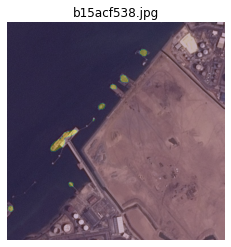

1/1 [==============================] - 0s 22ms/step


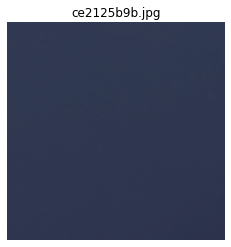

1/1 [==============================] - 0s 21ms/step


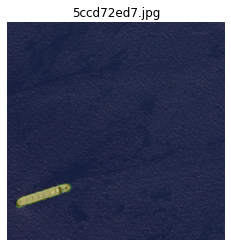

In [18]:
def cut_image(image, square_size):
	width, height = image.size
	x_steps = int(np.ceil(width / square_size))
	y_steps = int(np.ceil(height / square_size))

	squares = []
	
	for y in range(y_steps):
		for x in range(x_steps):
			x_start = x * square_size
			y_start = y * square_size
			x_end = min(x_start + square_size, width)
			y_end = min(y_start + square_size, height)
			
			square = image.crop((x_start, y_start, x_end, y_end))
			
			if x_end - x_start < square_size or y_end - y_start < square_size:
				# Extend the square to full size by creating a new image
				extended_square = Image.new('RGB', (square_size, square_size), (0, 0, 0))
				extended_square.paste(square, (0, 0))
				squares.append(np.array(extended_square))
			else:
				squares.append(np.array(square))
	
	return np.array(squares)

def join_images(image_arrays, square_size):
	x_steps = int(np.ceil(IMAGE_SIZE / square_size))
	y_steps = int(np.ceil(IMAGE_SIZE / square_size))
	image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 1))
	for y in range(y_steps):
		for x in range(x_steps):
			x_start = x * square_size
			y_start = y * square_size
			image[y_start:y_start + square_size, x_start:x_start + square_size] = image_arrays[y * x_steps + x]
	return image

def predict(row):
	path = get_image_path(row[0])
	image = Image.open(path)
	squares = cut_image(image, TARGET_SIZE)
	inputs = squares * 1.0 / 255
	masks = model.predict(inputs)
	single_mask = join_images(masks, TARGET_SIZE)
	render_pair(row[0], image, single_mask) 

predict(all_metadata[3])
predict(all_metadata[111])
predict(all_metadata[1])